An important calculation for this competition is to know how far a player is away from their teammates and opponents. There are several ways to calculate distance away from another player. This method is fast and can be scaled for all frames in a dataset and all weeks of player tracking data. The run time can be minutes (read: inefficient) but the code is readable and simple to understand.  

For this, I rely on `scipy` and some indexing techniques in `pandas` to generate distances from players and from the ball given every player on a unique game-play-frame. 

# Load data

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression

from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

In [2]:
# load players.csv to identify players by their name
players = pd.read_csv("../input/nfl-big-data-bowl-2023/players.csv")

# load data to calculate distances from players on the field (and also the distance from the football)
scout = pd.read_csv("../input/nfl-big-data-bowl-2023/pffScoutingData.csv")
data = pd.read_csv("../input/nfl-big-data-bowl-2023/week1.csv")

# merge scout data onto the tracking data 
data = data.merge(scout, how='left')

# Create distances from each player on a play 
I use PFF's `pff_positionLinedUp` data to assign what position a player is playing given their presnap positioning on a play. This can be more complex (or less) as designed by the developer. This is just one simple example -- I would recommend to craft your own version of this. 

For the interest of run time, I limit this to only the first frame in a play. You can loop through all frames if you want. In the cell below, you would need to nest one more for loop. Again, there is most likely a more efficient way to do this -- nested for loops are not typically efficient and usually some sort of vectorization can be engineered in lieu of a for loop. (Usually.) 

In [3]:
# create an empty output dataframe to append data into 
df_presnap = pd.DataFrame()

# loop through each game 
for gid in data['gameId'].unique():
  # subset the data down to one game
  one_game = data.loc[data['gameId']==gid]

  # loop through each play
  for pid in one_game['playId'].unique():

    # subset game data down to one play 
    one_play = one_game.loc[one_game['playId']==pid]

    # isolate the first frame of data only (you could also loop through all frames if you so choose. this example is supposed to be a short demo)
    one_frame = one_play.loc[one_play['frameId']==1]

    # reset index (saving the original index as a column) and set new index as player ID 
    one_frame = one_frame.reset_index().set_index('nflId')

    # turn PFF player positioning info into unique positions given the play (for modeling purposes)
    one_frame['pff_positionLinedUp'] = one_frame['pff_positionLinedUp'] + one_frame.groupby('pff_positionLinedUp', as_index=False).cumcount().astype(str).str.replace('0', '')
    
    # get pairwise distance, turn it into a pairwise matrix, set it in a pandas dataframe with index as nflId and columns as positions 
    _df = pd.DataFrame(squareform(pdist(one_frame.loc[:, ['x','y']])), index=one_frame.index, columns=one_frame['pff_positionLinedUp'].unique())

    # concat pairwise matrix column-wise onto original one_frame data
    one_frame = pd.concat([one_frame,_df], axis=1).rename(columns={np.nan:'dist_from_ball'})

    # change index back to nflId column, set the column "index" to the true index 
    one_frame = one_frame.reset_index().set_index('index')

    # clear the index name for prettyfication 
    one_frame.index.name = None

    # append to output dataframe
    df_presnap = df_presnap.append(one_frame)

# fill the nulled sparse positions with -1, indicating that position was not apparent on a given play and/or frame
positions = [x for x in df_presnap.columns.values if x not in one_game.columns.values]
df_presnap.loc[:, positions] = df_presnap.loc[:, positions].fillna(-1)    

In [4]:
# Random samples of distances away from the football and QB 
df_presnap.loc[:, ['nflId', 'pff_positionLinedUp', 'gameId', 'playId','QB', 'dist_from_ball']].sample(5)

,nflId,pff_positionLinedUp,gameId,playId,QB,dist_from_ball
146221,NaN,NaN,2021091200,3728,4.700011,0.000000
298610,53437.0,LCB,2021091202,3675,20.263151,17.568773
644411,42401.0,LOLB,2021091207,2856,7.792779,5.290085
735102,46099.0,RCB,2021091209,265,11.651562,9.972768
1065237,52479.0,NT,2021091300,1984,5.321137,0.850000


You can see in the random samples above that for any player in a play, we have distances from the QB and from the football. We can also see how a player lined up on this play given the `pff_positionLinedUp`. At this point, you have created distances from each player and the football! Woo hoo! 

# Extremely simple use-case for distance usage 
Say we wanted to create a really simple model where we isolate players in the pass block and try to guess the probability they will give up a pressure on the QB. We can use a player's XY location and their distances away from all other players and the football to determine QB pressure. 

Just like above, this is a very simplistic example. I would recommend pairing these features with other features to create a better "allowed pressure" model if that is what you aspire to do. 

In [5]:
# let's define "pressure allowed" as any time a player allowed a hit, sack, or hurry as defined by PFF's scouting data
df_presnap['pressure_allowed'] = df_presnap.loc[:, ['pff_hitAllowed', 'pff_hurryAllowed', 'pff_sackAllowed']].sum(axis=1)

# subset the data to only players on the "pass block" 
model_data = df_presnap.loc[df_presnap['pff_role']=='Pass Block']

# let's use an extremely simple feature set: a player's XY position and all the distances away from each player + the ball
feats = ['x', 'y'] + positions

# try to predict our new feature "pressure_allowed"
target = 'pressure_allowed'

# 5 fold group K-fold (where we group games together so as to not overfit on any potential game result leakage)
kf = GroupKFold(5)

# make an empty series to contain the new preds
preds = pd.Series()

# loop over the dataset, 80% train data, 20% test data
for train_idx, test_idx in kf.split(model_data, groups=model_data['gameId']):

  # split your train and test data by integer-position (aka 0 = row 0, 1 = row 1, etc)
  # if you aren't using sklearn pipeline or other convenience sklearn functions
  # KFold splits are outputted as integer-positions, not label-positions. so you will need to use .iloc (not .loc)
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  
  # train a simple logistic regression, default parameters blindly accepted
  model = LogisticRegression()
  model.fit(train_data.loc[:, feats], train_data[target])

  # predict on test set and store predictions to a series
  # remember since we're potentially going from numpy outputs to pandas, we can explicitly set our index to the test_data index for assurance in the concatenation
  _s = pd.DataFrame(model.predict_proba(test_data.loc[:, feats]), index=test_data.index)[1]
  
  # append preds to the preds series output
  preds = preds.append(_s)

# concatenate predictions to model_data dataset
model_data[f"{target}_pred"] = preds  

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations

Let's visualize our predictions with the actual pressures during the week. 

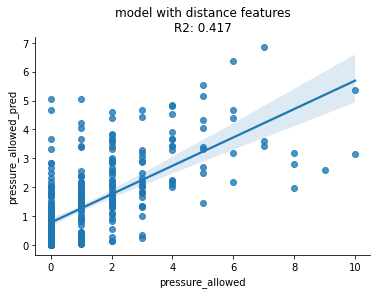

In [6]:
# groupby sum the target and the predicted target
df_plt = (model_data
          .loc[:, ['nflId', target, f'{target}_pred']]
          .groupby('nflId', as_index=False)
          .sum())

# calculate target over expected (pressures above or below prediction -- positive means worse pass blocking, negative means better pass blocking)
df_plt[f'{target}_over_expected'] = df_plt[target].sub(df_plt[f"{target}_pred"])

# join the names of the nfl players onto the dataset
df_plt = players.loc[:, ['nflId', 'displayName']].merge(df_plt)

# calculate R2 to show explained variance
r2 = pearsonr(df_plt[target], df_plt[f"{target}_pred"])[0]**2

# plot data
sns.regplot(data=df_plt, x=target, y=f'{target}_pred')
plt.title(f"model with distance features\nR2: {round(r2, 3)}")
sns.despine()
plt.show()

Even with a simple model, we seem to have signal in the aggregate. Great!  

Let's look at some tables to see who is allowing a lot of pressures. 

In [7]:
# This is sorted by actual pressures over the week 
df_plt.sort_values(target, ascending=False).head(10)

,nflId,displayName,pressure_allowed,pressure_allowed_pred,pressure_allowed_over_expected
266,52483,Jonah Jackson,10.0,5.359522,4.640478
40,41222,Alejandro Villanueva,10.0,3.134753,6.865247
98,43295,Ronnie Stanley,9.0,2.589700,6.410300
304,53497,Jalen Mayfield,8.0,2.792711,5.207289
279,52554,Tyler Biadasz,8.0,1.972205,6.027795
78,42410,A.J. Cann,8.0,3.198118,4.801882
137,44875,Dion Dawkins,7.0,3.424526,3.575474
84,42471,Jon Feliciano,7.0,3.602074,3.397926
249,48455,Matt Nelson,7.0,6.842045,0.157955
295,53443,Alijah Vera-Tucker,6.0,2.180758,3.819242


In [8]:
# This is sorted by predicted pressures over the week 
df_plt.sort_values(f'{target}_pred', ascending=False).head(10)

,nflId,displayName,pressure_allowed,pressure_allowed_pred,pressure_allowed_over_expected
249,48455,Matt Nelson,7.0,6.842045,0.157955
293,53436,Penei Sewell,6.0,6.356431,-0.356431
296,53446,Alex Leatherwood,5.0,5.528111,-0.528111
266,52483,Jonah Jackson,10.0,5.359522,4.640478
116,43453,Halapoulivaati Vaitai,5.0,5.141802,-0.141802
102,43320,Germain Ifedi,1.0,5.071366,-4.071366
181,46131,Brian O'Neill,0.0,5.052263,-5.052263
178,46106,Braden Smith,4.0,4.863906,-0.863906
273,52517,John Simpson,4.0,4.810226,-0.810226
82,42445,Daryl Williams,6.0,4.668867,1.331133


The above examples show how many pressures a player gave up but "good" pass blockers may given up 0 in a week. It's hard to tell the best pass blockers when all have 0 pressures allowed. 

Let's use our "pressure allowed over expected" feature to determine who gave up more pressures than expected and also who gave up the least pressures than expected. Negative values will indicate players who allowed fewer pressures than expected -- and the most negative values would represent players who pass-blocked the best during the week. 

In [9]:
# These are the players who allowed the most pressures over expected (poor performances in this week)
df_plt.sort_values(f'{target}_over_expected', ascending=False).head(10)

,nflId,displayName,pressure_allowed,pressure_allowed_pred,pressure_allowed_over_expected
40,41222,Alejandro Villanueva,10.0,3.134753,6.865247
98,43295,Ronnie Stanley,9.0,2.589700,6.410300
279,52554,Tyler Biadasz,8.0,1.972205,6.027795
304,53497,Jalen Mayfield,8.0,2.792711,5.207289
78,42410,A.J. Cann,8.0,3.198118,4.801882
266,52483,Jonah Jackson,10.0,5.359522,4.640478
295,53443,Alijah Vera-Tucker,6.0,2.180758,3.819242
137,44875,Dion Dawkins,7.0,3.424526,3.575474
140,44882,Pat Elflein,5.0,1.455481,3.544519
84,42471,Jon Feliciano,7.0,3.602074,3.397926


In [10]:
# These are the players who allowed the least pressures over expected (good performances in this week)
df_plt.sort_values(f'{target}_over_expected', ascending=False).tail(10)

,nflId,displayName,pressure_allowed,pressure_allowed_pred,pressure_allowed_over_expected
167,46075,Quenton Nelson,1.0,3.668170,-2.668170
17,38553,Riley Reiff,0.0,2.835375,-2.835375
33,40089,Oday Aboushi,0.0,2.838925,-2.838925
148,44972,Jermaine Eluemunor,1.0,4.038813,-3.038813
9,37082,Tyron Smith,1.0,4.221546,-3.221546
294,53442,Rashawn Slater,0.0,3.338995,-3.338995
41,41232,Jake Matthews,0.0,3.662454,-3.662454
102,43320,Germain Ifedi,1.0,5.071366,-4.071366
62,41939,Andrew Norwell,0.0,4.664862,-4.664862
181,46131,Brian O'Neill,0.0,5.052263,-5.052263


# If you liked this notebook, please upvote! 

# Follow me on twitch to see me develop these notebooks LIVE https://twitch.tv/nickwan_datasci  
# Follow me on twitter to idk why, just vibe i guess https://twitter.com/nickwan 